**Note to Chris & Nick:** Any weaknesses in this analysis are my (Kim's) fault for not having started sooner when help was available! Alvin & Patrick did a stellar job.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import re
from math import ceil
from theano import shared
sns.set()

from sklearn import preprocessing, model_selection
from pymc3 import forestplot, traceplot, autocorrplot, gelman_rubin, geweke, effective_n, energyplot, bfmi

In [5]:
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

I'll be working with the singly imputed data that Alvin produced in `imputed.ipynb`, due to the high degree of missingness in some variables of interest in the data. Because PyMC3's `GLM` model quietly ignores missing observations, I'll need to use the imputed data sets to keep all of my models comparable in terms of number of observations.

I initially attempted to do Bayesian imputation of the missing values using PyMC3 but quickly ran into difficulty estimating the missing values due to the ~10% missingness present in the data set.

In [6]:
train = pd.read_csv('../data/train_imputed.csv')
valid = pd.read_csv('../data/valid_imputed.csv')
test = pd.read_csv('../data/test_imputed.csv')

X = pd.concat([train,valid,test]).drop('Unnamed: 0', axis = 1).reset_index(drop = True) # using all the data available for estimation

In [4]:
X.columns = list(X.columns.str.replace(" |, |\.","_").str.lower())
# processing the column names so they play nicely with patsy/glm

In [9]:
# id_vars = list(df.columns[0:3]) + ['total_encounters','group','dob','dod']
meds = list(X.columns[X.columns.str.contains('med_')])
cpts = list(X.columns[X.columns.str.contains('cpt_')])
dx = list(X.columns[X.columns.str.contains('icd_dx')])
labs = list(X.columns[X.columns.str.contains('lab_')])
bmi = list(X.columns[X.columns.str.contains('bmi|pregnancy')])
demos = ['age','sex']
outcomes = ['readmit_time','readmit_30d']
visit = cpts + ['n_transfers','stay_length','icd_proc','icd_visit']
final_var = demos + bmi + dx + labs + visit
# drop meds; can't use them right off the bat -- they cause problems with chain failure due to their sparsity

In [10]:
# select various different lab measures -- using all of them is redundant
labs_median = list(X.columns[X.columns.str.contains('lab_.*_median')])
labs_last = list(X.columns[X.columns.str.contains('lab_.*_last')]) + ['lab_systolic_median','lab_diastolic_median']
labs_extremes = list(X.columns[X.columns.str.contains('lab_.*5p')])
labs_var = list(X.columns[X.columns.str.contains('lab_.*_std')])
# redundancy analysis suggests the lab variability contains the most information not included in other variables

In [7]:
visit_desc = X[visit].describe()
dx_desc = X[dx].describe()
labs_desc = X[labs].describe()
demos_desc = X[demos].describe()

In [8]:
trans_var = ['age'] + labs + ['bmi_last'] + cpts
scaler = preprocessing.StandardScaler()

X[trans_var] = scaler.fit_transform(X[trans_var])

# some variables need to be transformed to work well in the glm

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Model fitting

JUST MAIN EFFECTS REGRESSION MODELS? WOULD HAVE BEEN GOOD TO HAVE EXPLORED ANY HIERARCHICAL STRUCTURE OR RANDOM EFFECTS, AS WELL AS INTERACTIONS. PLOTS OF THE INPUTS WOULD HAVE BEEN HELPFUL.

ALSO PROBABLY WORTH BEING MORE THOUGHTFUL ABOUT PRIORS.

In [11]:
def model_gen(outcome = 'readmit_30d', variables = bmi, data = X, draws = 1000):
    '''Utility function to quickly fit and sample a PyMC3 GLM model given a list of variables and a data set.'''
    import pymc3 as pm
    import pymc3.glm as glm
    
    formula = outcome + ' ~ ' + ' + '.join(variables)
    family = pm.glm.families.Binomial()
    
    with pm.Model() as model:
        glm.GLM.from_formula(formula,data,family = family)
    
        start = pm.find_MAP() # need to start at the MAP because otherwise the initial energies can cause the chains to fail
        
        trace = pm.sample(draws, start = start, random_seed = 420)
        
    return model, trace

MAP IS NOT A GOOD PLACE TO START, GENERALLY DUE TO THE FACT THAT THE MODE HAS LOW VOLUME. SEE SOME OTHER INITIALIZATION OPTIONS IN SAMPLE.

A quick summary table to describe each of the models below in a preliminary way. A slightly longer description has been included above the code for each model.

### Model descriptions
| Model name | Model formula | Model description |
|:------------------------------------|:---------------------------------------------------------------|:-----------------|
| Simple | P(30-day readmit) ~ invlogit(age + sex + BMI + pregnancy indicator) | Simplest model using demographic information and BMI only. |
| Visit | P(30-day readmit) ~ invlogit(simple model + CPT code counts + # transfers + length of stay + ICD9 visit & procedure codes) | Model making use of CPT code counts plus the number of times a patient was transferred between departments during a stay, and the length of the hospital stay. Also includes ICD9 code counts for the visit & procedure categories. |
| Diagnosis (dx) | P(30-day readmit) ~ invlogit(simple model + ICD9 diagnosis code counts) | Model making use of ICD9 diagnosis code counts for each stay. |
| Lab variability (labvar) | P(30-day readmit) ~ invlogit(simple model + lab value standard deviations ($\sigma$)) | Based on redundancy analysis and subject-matter knowledge, a model fitting versus the variability of labs seen over the patient's stay. This model will have difficulties in situations where a patient has only had one lab drawn during the course of the hospital visit, because no variance will exist in that case. |
| Extended | P(30-day readmit) ~ invlogit(simple model + visit variables + lab $\sigma$s + ICD9 dx codes) | Model combining the variables for the visit-based, diagnosis-based, and lab variability models. |
| "Clinical significance" (clinsignif) | P(30-day readmit) ~ invlogit(simple model + lab $\sigma$s + lab final values + CPTs for surgery, path labs, & radiology + # transfers + stay length) | Model reducing the visit variables to only a handful of CPTs of "clinical significance", as determined by a non-clinician. The addition of the final lab values is meant to compensate for the case where only a single lab of a given type was drawn for a visit. |
| Full | P(30-day readmit) ~ invlogit($\Sigma$ all non-med variables) | Model using all variables, including all different available statistics on in-stay lab values. |

### Simple model

The most basic model, incorporating only age, sex, BMI, and an indicator for whether the patient was pregnant at the time of the visit.

NOT CLEAR WHY YOU'RE TIMING THESE (PARTICULARLY FOR THE LONGER ONES). PYMC SAMPLE GIVES YOU THE TIME.

In [10]:
%%time
simple_model, simple_trace = model_gen(variables = demos + bmi, data = X, draws = 2000)

logp = -12,239, ||grad|| = 5.7006: 100%|██████████| 27/27 [00:00<00:00, 332.92it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pregnancy_indicator_last, bmi_last, age, sex[T.U], sex[T.M], Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:00<00:00, 82.08draws/s]

CPU times: user 8.78 s, sys: 1.07 s, total: 9.85 s
Wall time: 1min 11s


### Visit variables model

A set of visit variables defined by CPT code counts, ICD code counts for procedures and other visit-related operations, the number of transfers a patient went through during the visit, and the length of stay during the visit, along with the demographic and BMI variables from the simple model.

In [11]:
%%time
visit_model, visit_trace = model_gen(variables = demos + bmi + visit, data = X, draws = 2000)

logp = -12,205, ||grad|| = 1.6351: 100%|██████████| 88/88 [00:00<00:00, 288.18it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [icd_visit, icd_proc, stay_length, n_transfers, cpt_unknown, cpt_surgery, cpt_radiology, cpt_path_lab, cpt_modifier, cpt_medicine, cpt_expired, cpt_eval_manage, cpt_anesthesia, pregnancy_indicator_last, bmi_last, age, sex[T.U], sex[T.M], Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:40<00:00, 29.32draws/s]

CPU times: user 18.1 s, sys: 882 ms, total: 19 s
Wall time: 2min 51s


### Diagnosis code model

This model consists of ICD9 diagnosis code counts for the patient's visit, in addition to the variables from the simple model above.

In [12]:
%%time
dx_model, dx_trace = model_gen(variables = demos + bmi + dx, data = X, draws = 2000)

logp = -12,227, ||grad|| = 2.8586: 100%|██████████| 114/114 [00:00<00:00, 293.82it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [icd_dx_symptoms, icd_dx_skin, icd_dx_respiratory, icd_dx_perinatal, icd_dx_obstetric, icd_dx_nervous, icd_dx_neoplasm, icd_dx_muscskel, icd_dx_mental, icd_dx_injury, icd_dx_infection, icd_dx_gu, icd_dx_external, icd_dx_endocrine, icd_dx_digestive, icd_dx_congenital, icd_dx_circulatory, icd_dx_blood, pregnancy_indicator_last, bmi_last, age, sex[T.U], sex[T.M], Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:26<00:00, 34.09draws/s]


CPU times: user 22.9 s, sys: 1.06 s, total: 24 s
Wall time: 2min 42s


### Lab value variability model

Demographic variables from the simple model plus the variability (as defined by the standard deviation) of lab values over the patient's stay. There is some evidence in the literature that variability of treatment outcomes (vs any kind of central tendency of treatment outcomes) is more important when it comes to measuring a treatment's efficacy. Redundancy analysis (see `impute.ipynb`) suggested that as a class, the standard deviations for the lab values were worth retaining. Therefore, in order to reduce the number of variables we're fitting while still retaining information on the lab values, the standard deviations seemed the best set as a whole to pick.

In [13]:
%%time
labvar_model, labvar_trace = model_gen(variables = demos + bmi + labs_var, data = X, draws = 2000)

logp = -12,241, ||grad|| = 0.21049: 100%|██████████| 62/62 [00:00<00:00, 342.07it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lab_diastolic_std, lab_systolic_std, lab_wbc_std, lab_rdw_std, lab_rbc_std, lab_plt_ct_std, lab_pcv_std, lab_na_std, lab_mcv_std, lab_mchc_std, lab_mch_std, lab_k_std, lab_hgb_std, lab_gluc_std, lab_glubed_std, lab_creat_std, lab_cl_std, lab_ca_std, lab_co2_std, lab_bun_std, lab_an_gap_std, pregnancy_indicator_last, bmi_last, age, sex[T.U], sex[T.M], Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:40<00:00, 21.69draws/s]

CPU times: user 26.8 s, sys: 1.28 s, total: 28.1 s
Wall time: 3min


### Extended model

Combining available data from the models above to create a single larger model.

In [14]:
%%time
extended_model, extended_trace = model_gen(variables = demos + bmi + labs_var + visit + dx, data = X, draws = 2000)

logp = -12,353, ||grad|| = 3.459: 100%|██████████| 246/246 [00:01<00:00, 236.28it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [icd_dx_symptoms, icd_dx_skin, icd_dx_respiratory, icd_dx_perinatal, icd_dx_obstetric, icd_dx_nervous, icd_dx_neoplasm, icd_dx_muscskel, icd_dx_mental, icd_dx_injury, icd_dx_infection, icd_dx_gu, icd_dx_external, icd_dx_endocrine, icd_dx_digestive, icd_dx_congenital, icd_dx_circulatory, icd_dx_blood, icd_visit, icd_proc, stay_length, n_transfers, cpt_unknown, cpt_surgery, cpt_radiology, cpt_path_lab, cpt_modifier, cpt_medicine, cpt_expired, cpt_eval_manage, cpt_anesthesia, lab_diastolic_std, lab_systolic_std, lab_wbc_std, lab_rdw_std, lab_rbc_std, lab_plt_ct_std, lab_pcv_std, lab_na_std, lab_mcv_std, lab_mchc_std, lab_mch_std, lab_k_std, lab_hgb_std, lab_gluc_std, lab_glubed_std, lab_creat_std, lab_cl_std, lab_ca_std, lab_co2_std, lab_bun_std, lab_an_gap_std, pregnancy_indicator

CPU times: user 1min 1s, sys: 2.65 s, total: 1min 4s
Wall time: 6min 50s


### "Clinical significance" model

"Clinically significant" visit variables, as defined by a non-clinician, without reference to how any of the models above are doing. I select a set of variables I believe characterize how a patient's hospital stay might be going--looking for evidence that they're having repeated pathology labs done or had an event, such as surgery, that puts them at higher risk for a readmission, without regard to their particular diagnoses.

In [15]:
clin_cpts = ['n_transfers', 'stay_length', 'cpt_path_lab', 'cpt_surgery', 'cpt_radiology', 'cpt_anesthesia']

In [16]:
%%time
clinsignif_model, clinsignif_trace = model_gen(variables = demos + bmi + clin_cpts + labs_var + labs_last, data = X, draws = 2000)

logp = -12,128, ||grad|| = 1.22: 100%|██████████| 95/95 [00:00<00:00, 255.12it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lab_diastolic_median, lab_systolic_median, lab_wbc_last_measure, lab_rdw_last_measure, lab_rbc_last_measure, lab_plt_ct_last_measure, lab_pcv_last_measure, lab_na_last_measure, lab_mcv_last_measure, lab_mchc_last_measure, lab_mch_last_measure, lab_k_last_measure, lab_hgb_last_measure, lab_gluc_last_measure, lab_glubed_last_measure, lab_creat_last_measure, lab_cl_last_measure, lab_ca_last_measure, lab_co2_last_measure, lab_bun_last_measure, lab_an_gap_last_measure, lab_diastolic_std, lab_systolic_std, lab_wbc_std, lab_rdw_std, lab_rbc_std, lab_plt_ct_std, lab_pcv_std, lab_na_std, lab_mcv_std, lab_mchc_std, lab_mch_std, lab_k_std, lab_hgb_std, lab_gluc_std, lab_glubed_std, lab_creat_std, lab_cl_std, lab_ca_std, lab_co2_std, lab_bun_std, lab_an_gap_std, cpt_anesthesia, cpt_radiology

CPU times: user 57.9 s, sys: 2.72 s, total: 1min
Wall time: 6min 31s


### Full model

All available information on the patient (*sans* race and EGFR values, which we elected as a group to omit from our analysis) are included in this model, including all summary statistics created for lab values. This is the "kitchen sink" model, meant to examine whether all the available data we have or can devise on a patient yields better insight into her likelihood of readmission.

This probably takes as long to run as it does because including all the lab values results in high collinearity between a very large set of variables.

In [17]:
%%time
full_model, full_trace = model_gen(variables = final_var, data = X, draws = 2000)

logp = -12,781, ||grad|| = 6.5555: 100%|██████████| 692/692 [00:05<00:00, 120.72it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [icd_visit, icd_proc, stay_length, n_transfers, cpt_unknown, cpt_surgery, cpt_radiology, cpt_path_lab, cpt_modifier, cpt_medicine, cpt_expired, cpt_eval_manage, cpt_anesthesia, lab_diastolic_std, lab_systolic_std, lab_diastolic_95p, lab_systolic_95p, lab_diastolic_5p, lab_systolic_5p, lab_diastolic_median, lab_systolic_median, lab_wbc_std, lab_rdw_std, lab_rbc_std, lab_plt_ct_std, lab_pcv_std, lab_na_std, lab_mcv_std, lab_mchc_std, lab_mch_std, lab_k_std, lab_hgb_std, lab_gluc_std, lab_glubed_std, lab_creat_std, lab_cl_std, lab_ca_std, lab_co2_std, lab_bun_std, lab_an_gap_std, lab_wbc_last_measure, lab_rdw_last_measure, lab_rbc_last_measure, lab_plt_ct_last_measure, lab_pcv_last_measure, lab_na_last_measure, lab_mcv_last_measure, lab_mchc_last_measure, lab_mch_last_measure, lab

CPU times: user 3min 49s, sys: 8.03 s, total: 3min 57s
Wall time: 1h 3s


## Model Diagnostics

In [19]:
model_descs = {simple_trace: 'simple demographics', full_trace: 'all variables', visit_trace: 'visit-specific variables',
               dx_trace: 'ICD9 diagnosis codes', labvar_trace: 'lab value σs',
               extended_trace: 'demographic, visit, diagnosis, and lab σ variables', 
               clinsignif_trace: '"clinically significant" variables' }

### Energy Plots & BFMI

Visual inspection of the energy plots below yields no overall cause for concern for any of the models (though the simple model's energy plot looks slightly wonky). None of them experienced a significant number of divergences during estimation and all (per the output diagnostics provided by `sample`) had R-hats for all variables below 1.2. I'll look at individual variables next.

In [20]:
# plt.rcParams['figure.figsize'] = [7,4]

# note: the following function is very brittle because it relies on the model_descs dictionary to be correctly defined
# & the trace names to be invariant

def mult_energyplot(traces = [simple_trace, visit_trace, dx_trace, labvar_trace, extended_trace, clinsignif_trace, full_trace]):
    
    from math import ceil
    
    n_rows = ceil(len(traces)/2)
    fig, ax = plt.subplots(n_rows,2,figsize = [16,5*n_rows])

    for axis,trace in zip(ax.flatten(),traces):
        energyplot(trace, ax = axis)
        axis.set_title(label = 'Model: {mdesc}\nBFMI = {bfmi}'.format(mdesc = model_descs[trace], bfmi = bfmi(trace).round(3)))
    
    if len(traces) % 2:
        axis = ax.flatten()[len(ax.flatten())-1]
        axis.axis('off')

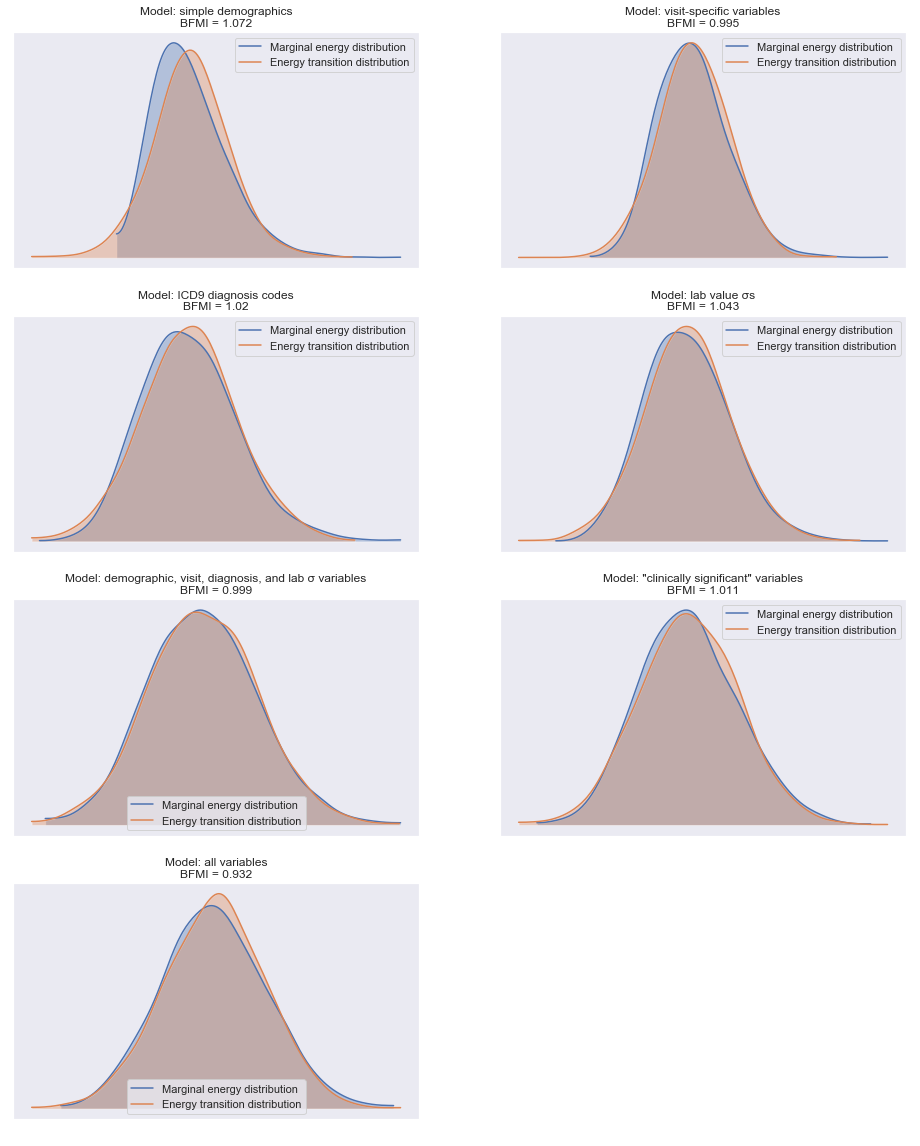

In [21]:
mult_energyplot();

## Examining variable estimates & troubleshooting problem variables

We'll next inspect variable estimation for the models, using the variable groupings defined above in order to make the larger models more comprehensible.

As a completely ad hoc heuristic to make my life easier, I'm only going to look at trace plots for the larger models where > 80% of the posterior distribution's mass is above or below zero; ORs where this isn't the case are less interesting to me because we do not have enough information to narrow down the real effect of these variables with any confidence. (And, therefore, I'm a little less worried if the model is estimating them strangely -- though they may constrain the shape of the posterior in strange ways for variables that are highly correlated with them.)

In [186]:
traces = [simple_trace, visit_trace, dx_trace, labvar_trace, extended_trace, clinsignif_trace, full_trace]
model_names = ['simple','visit','dx','labvar','extended','clinsignif','full']

In [12]:
def var_selector(trace, cutoff = 0.8):
    
    var_masses = {}
    
    for var in trace.varnames:
        varval = trace[var]
        vm = max([sum(varval > 0)/len(varval), sum(varval < 0)/len(varval)])
        var_masses[var] = vm
    
    return [key for key in var_masses if var_masses[key] > cutoff]

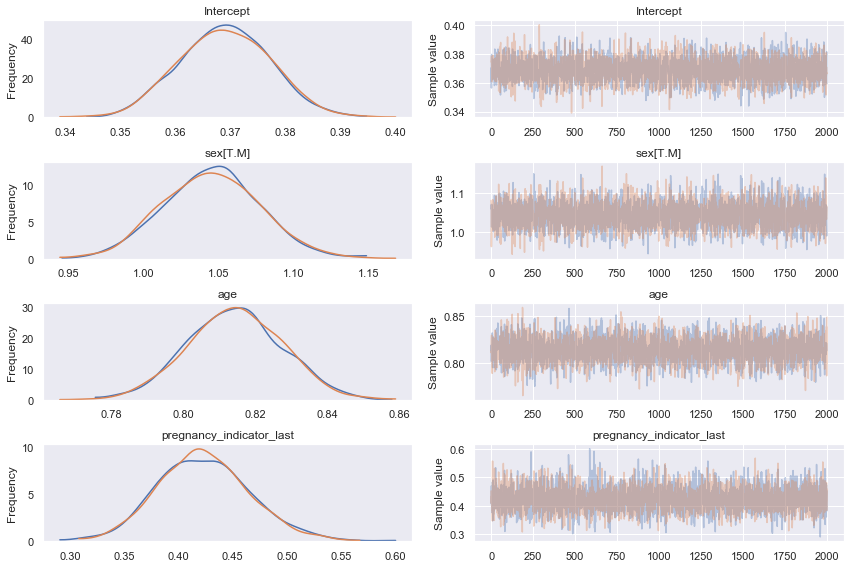

In [172]:
traceplot(simple_trace, varnames = var_selector(simple_trace), transform = np.exp);

TRACEPLOTS ARENT SUPER INFORMATIVE HERE. BEST TO USE FOREST PLOTS.

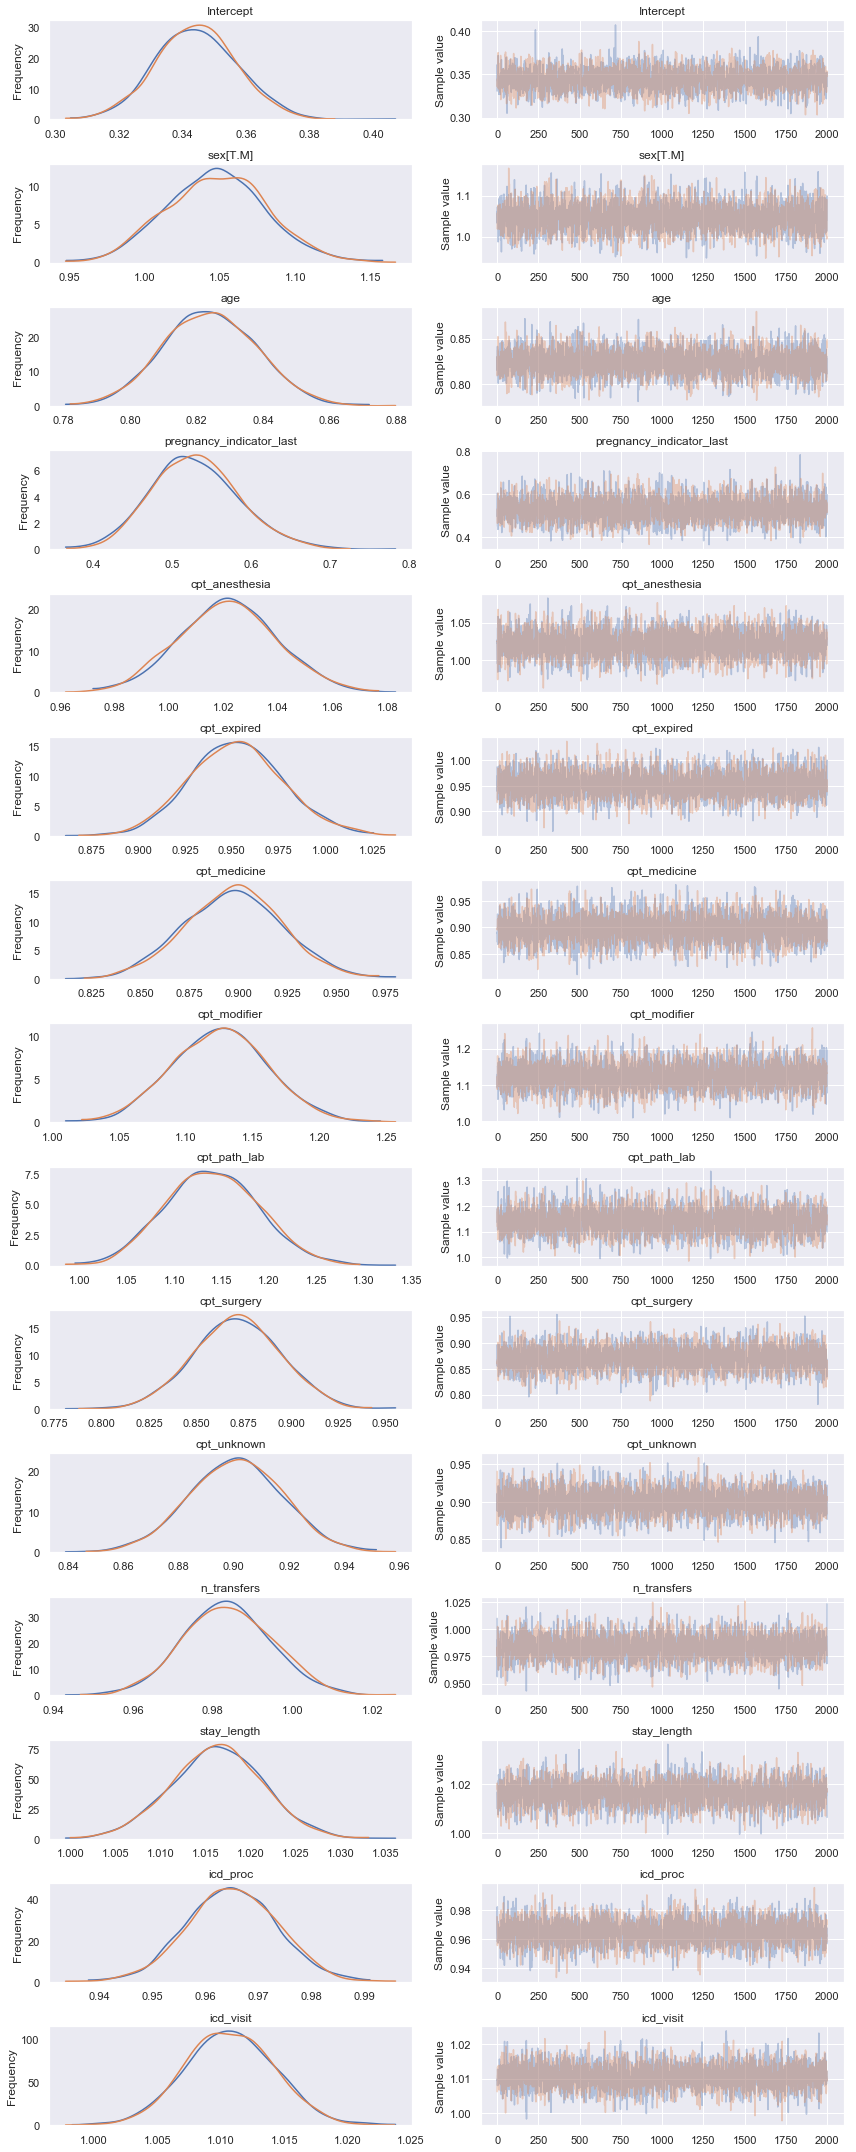

In [173]:
traceplot(visit_trace, varnames = var_selector(visit_trace), transform = np.exp);

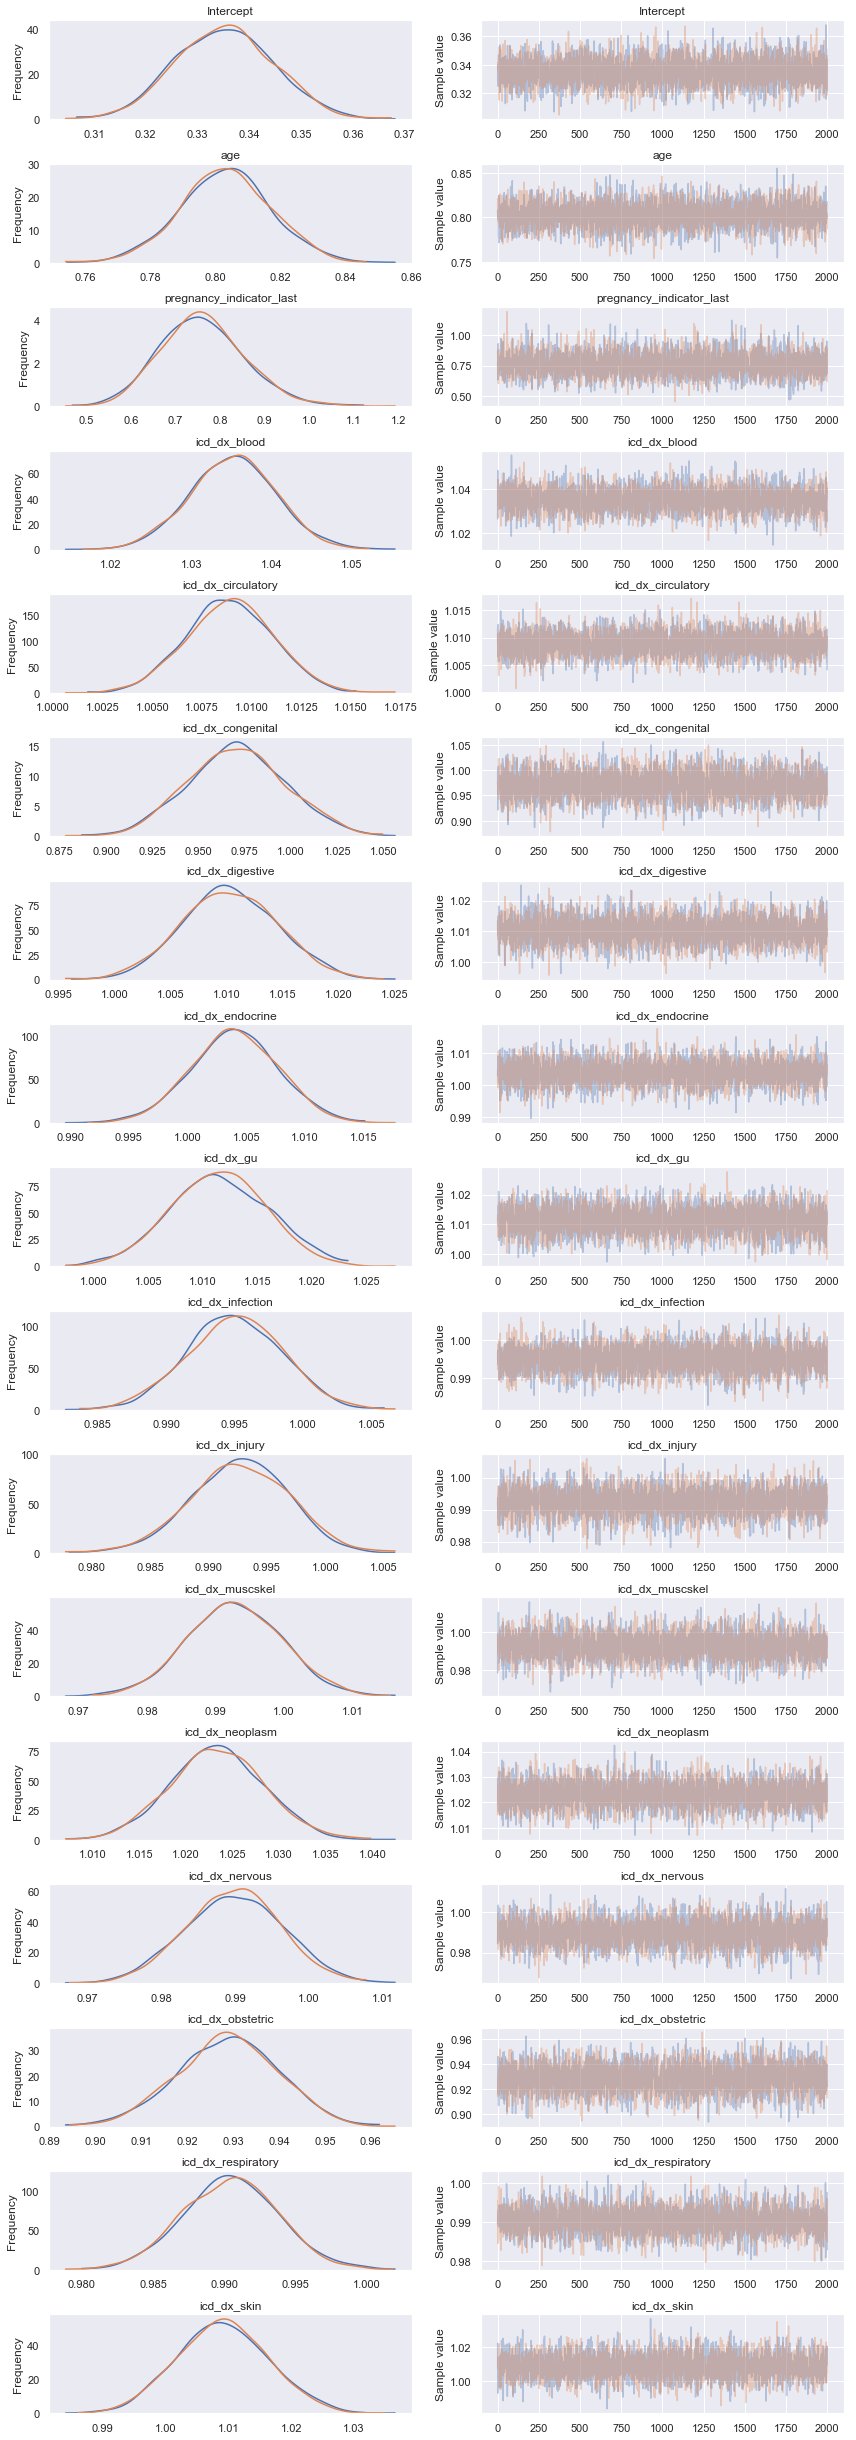

In [174]:
traceplot(dx_trace, varnames = var_selector(dx_trace), transform = np.exp);

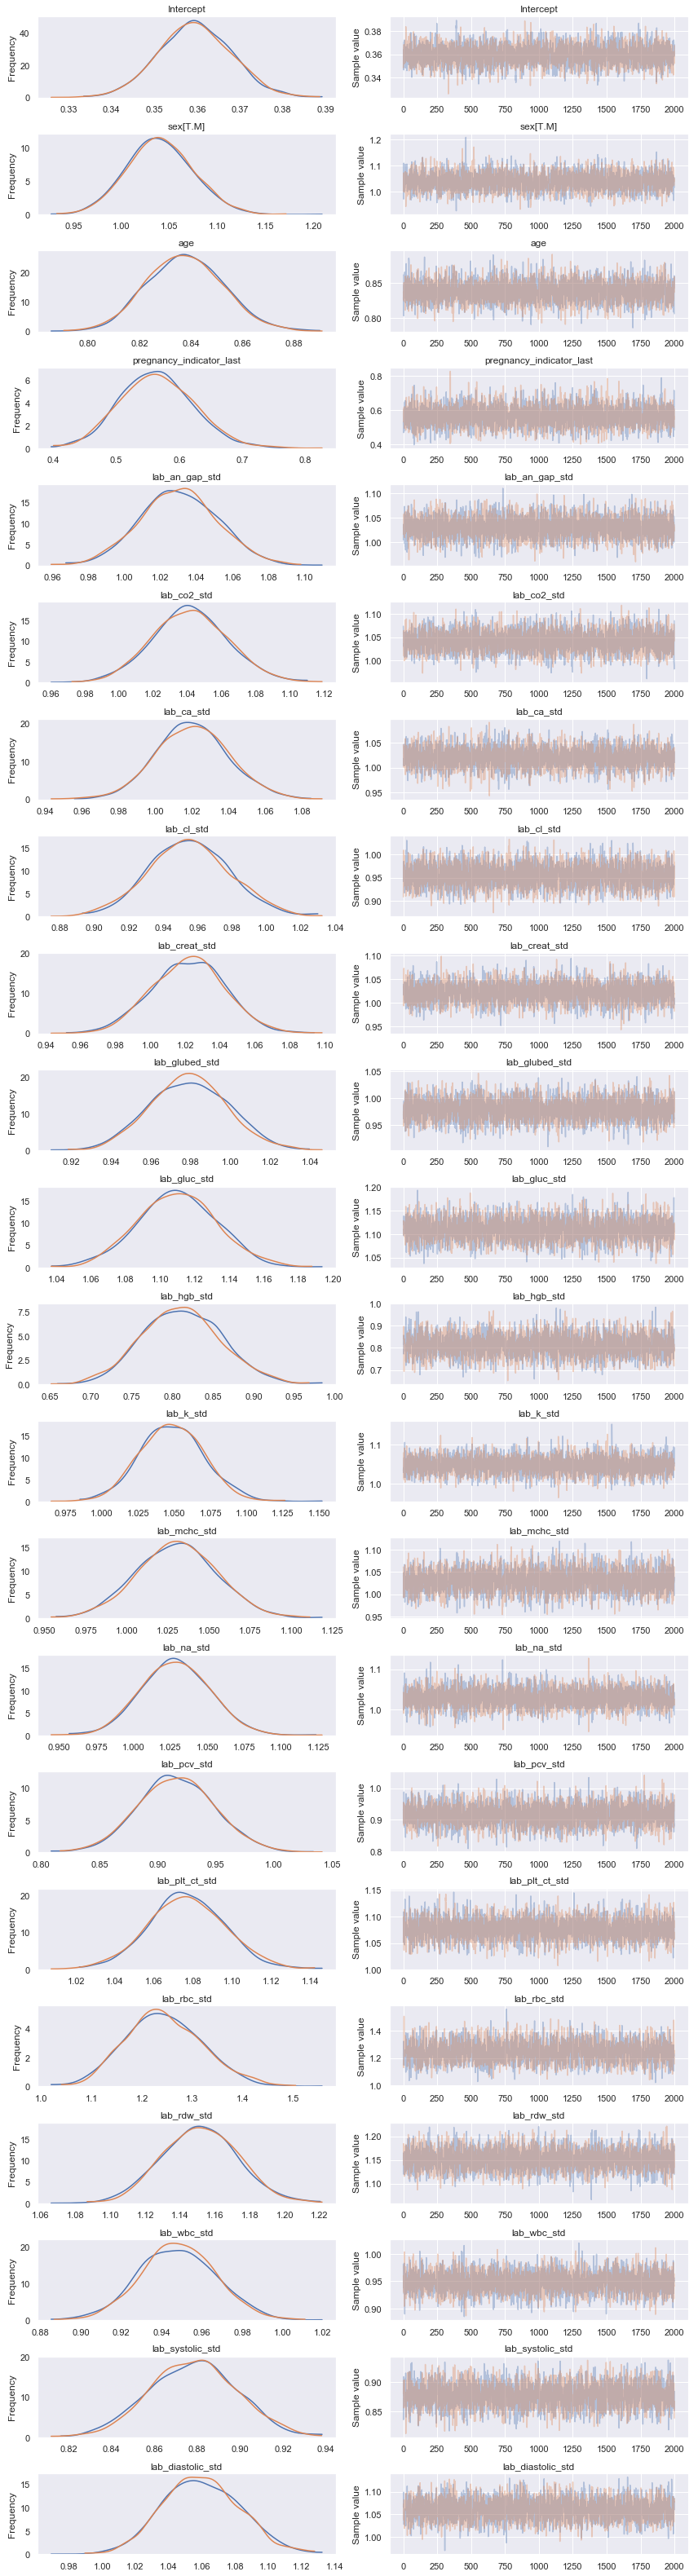

In [175]:
traceplot(labvar_trace, varnames = var_selector(labvar_trace), transform = np.exp);

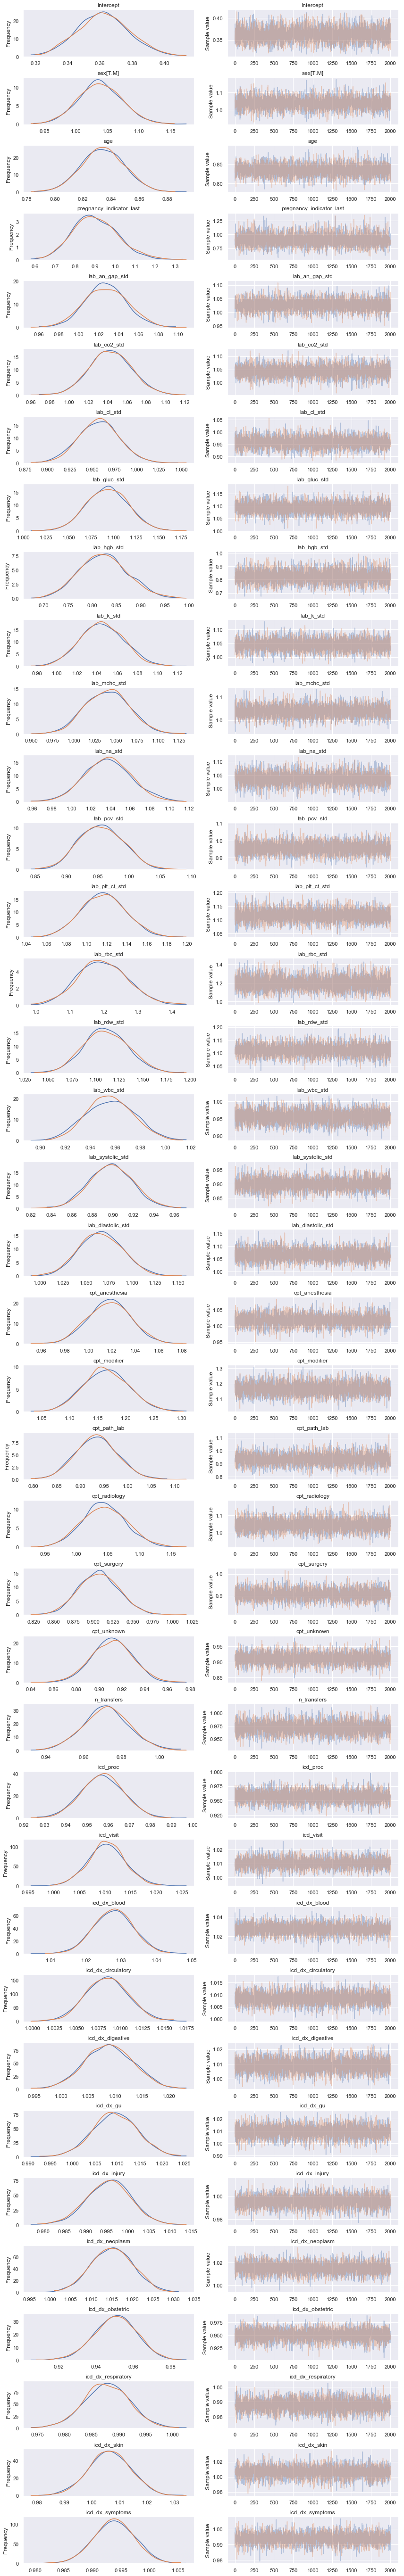

In [176]:
traceplot(extended_trace, varnames = var_selector(extended_trace), transform = np.exp);

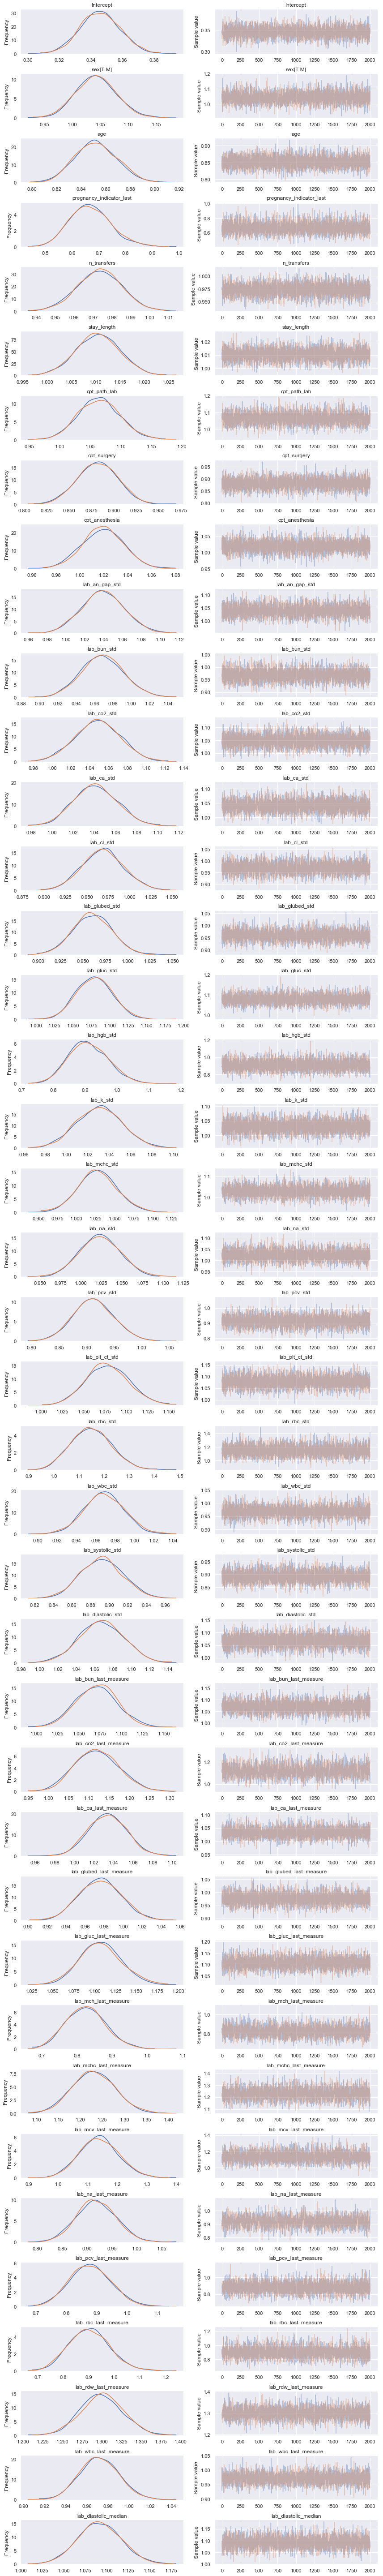

In [177]:
traceplot(clinsignif_trace, varnames = var_selector(clinsignif_trace), transform = np.exp);

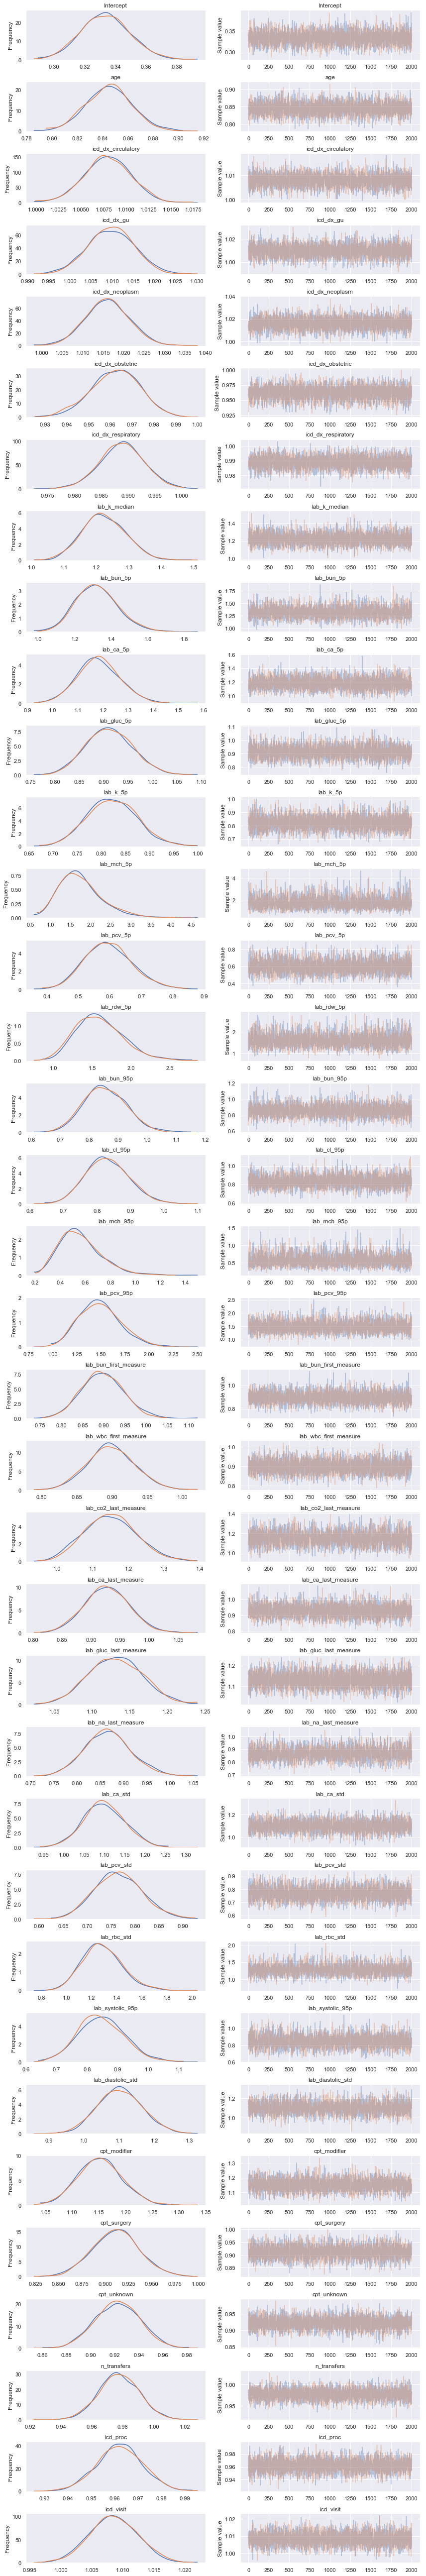

In [179]:
traceplot(full_trace, varnames = var_selector(full_trace, cutoff = 0.95), transform = np.exp);

(For the full trace, I elected to use a cutoff of 0.95 because otherwise there's just too many variables.)

Examination of the above traces for all models yields that the sampler is doing fairly well at exploring the space of the posterior, though there are some constrictions in many of the trace plots that imply it's getting stuck in places. This is probably due to the shape of the multidimensional space it's operating over -- I expect the joint posterior distribution is very unusual with a lot of gaps because there's so many dimensions involved at this point, and many of our variables are highly related to each other. To examine this idea:

In [209]:
full_trace_df = pm.trace_to_dataframe(full_trace)

In [218]:
full_trace_df.columns[full_trace_df.columns.str.contains("systolic")]

Index(['lab_systolic_median', 'lab_systolic_5p', 'lab_systolic_95p',
       'lab_systolic_std'],
      dtype='object')

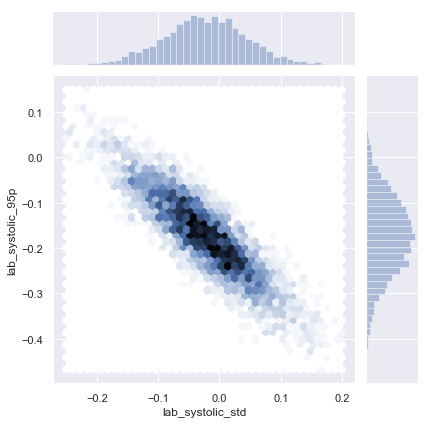

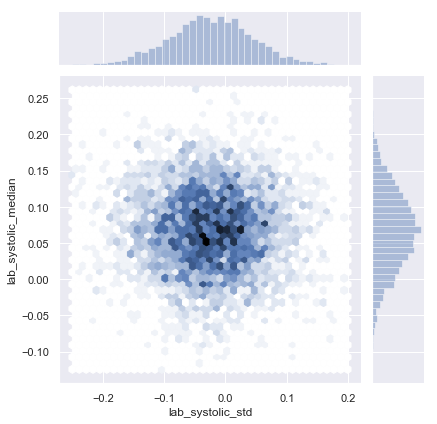

In [220]:
_ = sns.jointplot("lab_systolic_std","lab_systolic_95p", data=full_trace_df, kind = 'hex')
_ = sns.jointplot("lab_systolic_std","lab_systolic_median", data=full_trace_df, kind = 'hex')
# as one expects from something assumed normal, the median & std are uncorrelated, almost

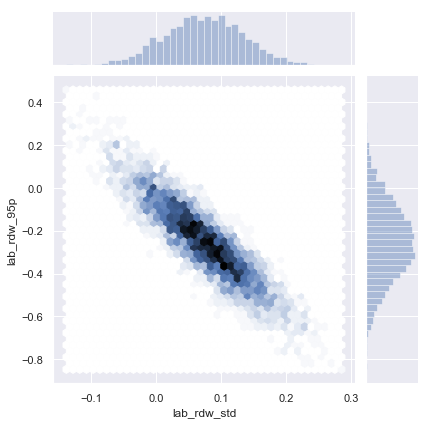

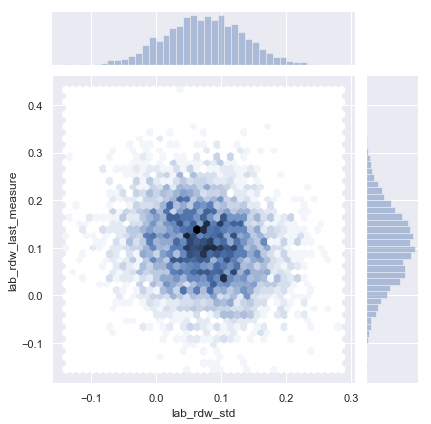

In [221]:
_ = sns.jointplot("lab_rdw_std","lab_rdw_95p", data=full_trace_df, kind = 'hex')
_ = sns.jointplot("lab_rdw_std","lab_rdw_last_measure", data=full_trace_df, kind = 'hex')
# also, the last measure & the std tend to be uncorrelated, further justifying the use of both in the clinical significance model

The best fix for this particular problem is not to use so many correlated variables, arguing for a more parsimonious model.

Next, I'll examine the forest plots to get a better idea of which variables are predictive of hospital readmissions.

#### Demographic & BMI variables

CONTEXT MANAGERS ARE GREAT FOR TEMPORARILY CHANGING PLOTTING PARAMETERS

In [193]:
plt.rcParams['figure.figsize'] = [12,8]
forestplot(traces, varnames = ['sex[T.M]'] + bmi, models = model_names, colors = 'cycle');
# dummy variable for unknown sex omitted because the width of the CR was messing up my plots & making everything else hard to see
# they're largely not informative

In general, female sex and current pregnancy appear to be protective against a 30-day readmission. Based on the literature, I would have expected that BMI would have more weight to it--but I suspect the reason it does not is because its relationship to the outcome is more complicated than linear, since both low BMIs & high BMIs are associated with poor health outcomes (and therefore possible hospital readmissions).

#### Visit-related variables

WHY ARE SOME VARIABLES' PLOTS MISSING?

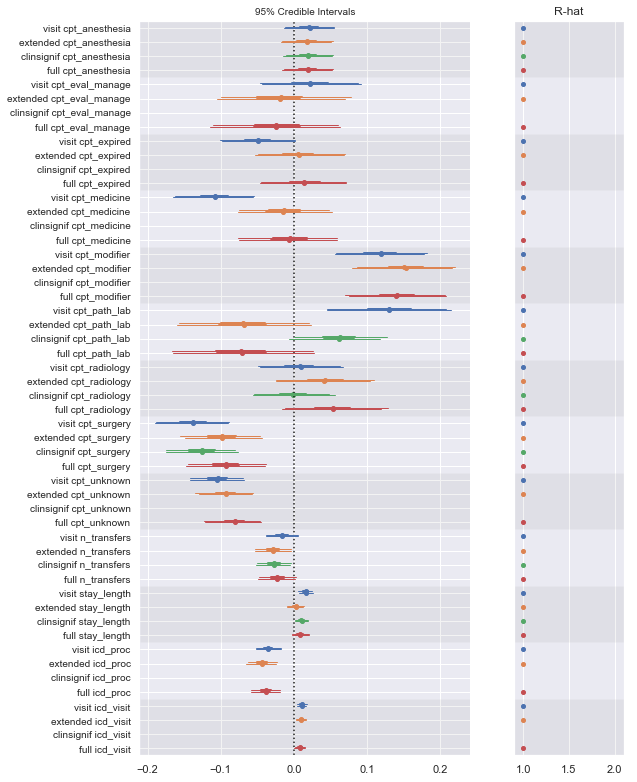

In [27]:
plt.rcParams['figure.figsize'] = [12,12]
forestplot([traces[i] for i in [1,4,5,6]], varnames = visit, models = [model_names[i] for i in [1,4,5,6]], colors = 'cycle');

#### Diagnosis code counts
Here, I note one variable -- the OR for the count of 'perinatal' ICD9 codes -- has an unusually wide estimated posterior in the full model. I'll extract that and display it separately.

This unusually wide interval on an odds ratio is some evidence of a model failure brought on by there being very few patients that have a non-zero value for the `icd_dx_perinatal` variable (see below). In essence, model estimations for that variable are happening on a set of patients that are effectively unique when all other variables are taken together, leading to strange behavior in the posterior and the vastly inflated odds ratios.

I note that other rare code categories, such as the one for congenital disorders, also display this behavior.

In [29]:
X.icd_dx_perinatal.value_counts()

0    21119
1       11
4        2
2        1
Name: icd_dx_perinatal, dtype: int64

In [115]:
X.icd_dx_congenital.value_counts()

0     20146
1       676
2       148
3        47
4        39
5        26
6        19
7        12
8         7
17        3
15        3
9         2
14        1
25        1
10        1
11        1
16        1
Name: icd_dx_congenital, dtype: int64

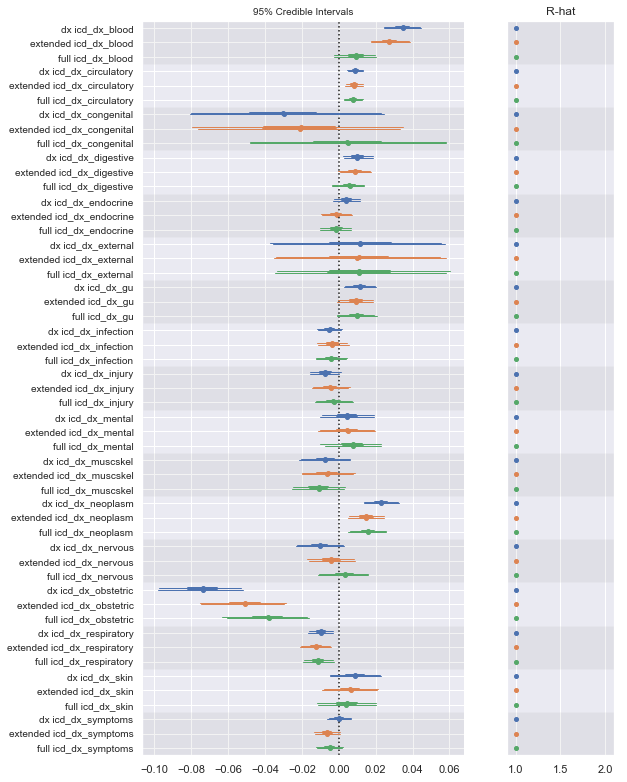

In [30]:
plt.rcParams['figure.figsize'] = [12,12]
dxcp = dx.copy()
dxcp.remove('icd_dx_perinatal')

forestplot([traces[i] for i in [2,4,6]], varnames = dxcp, models = [model_names[i] for i in [2,4,6]], colors = 'cycle');

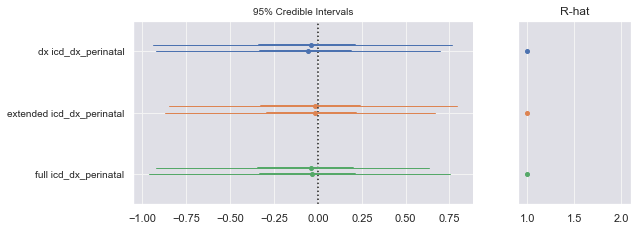

In [31]:
plt.rcParams['figure.figsize'] = [12,3]
forestplot([traces[i] for i in [2,4,6]], varnames = ['icd_dx_perinatal'], models = [model_names[i] for i in [2,4,6]], colors = 'cycle');

ICD9 codes for blood disorders are unsurprisingly predictive of 30-day readmissions; sickle-cell anemia leads to frequent readmissions, many of them in less than thirty days from the previous readmission. Similarly, neoplasms (cancer) codes are linked to an increased risk of 30-day readmission. I'm at a loss to explain what's going on with the obstetrics situation.

However, in the full model, these rapidly lose their relevance -- I suspect because lab values provide more direct information about a patient's status and likelihood of return than do diagnosis codes.

#### Lab values

Because most of the models only use standard deviations for all lab values over the hospital visit, I will plot these separately from the forest plot for the full model, which uses every lab variable available. Note again the credible intervals for ORs in the full model are extremely wide relative to the other models, implying the presence of other variables in the model is distorting the posterior estimates here.

I will plot the models without the inclusion of the full model so the scale of the ORs for the remaining models is more clear.

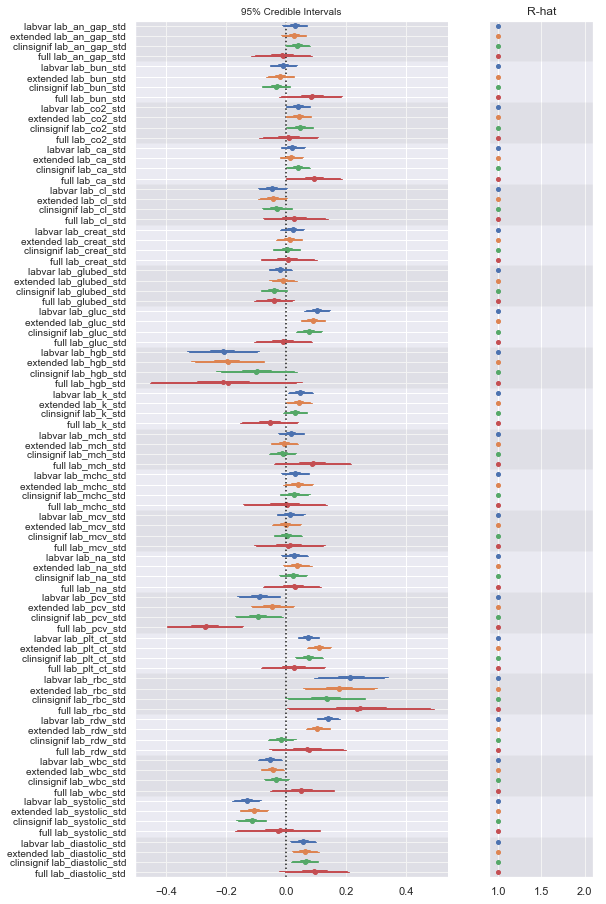

In [32]:
plt.rcParams['figure.figsize'] = [12,14]

forestplot(traces[3:7], varnames = labs_var, models = model_names[3:7], colors = 'cycle');

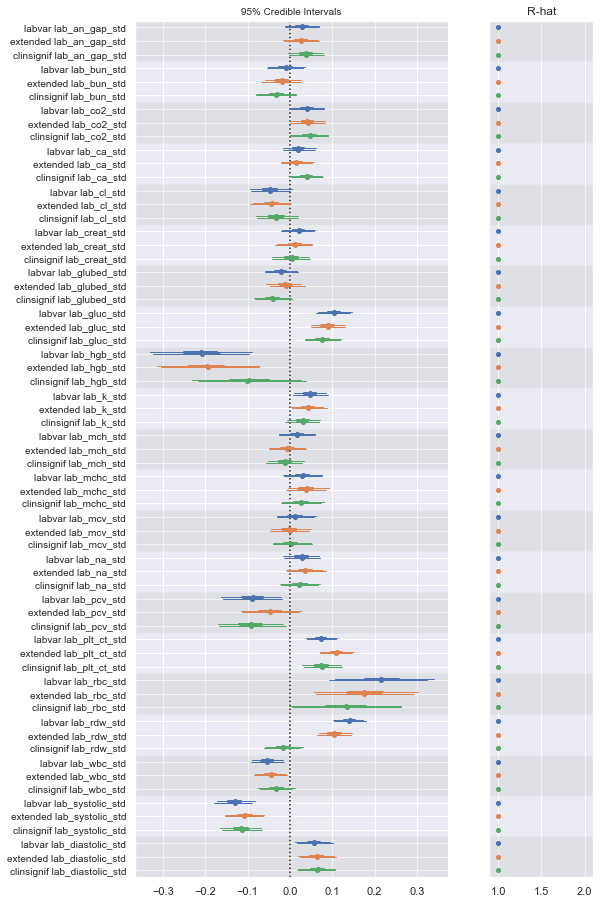

In [33]:
plt.rcParams['figure.figsize'] = [12,14]

forestplot(traces[3:6], varnames = labs_var, models = model_names[3:6], colors = 'cycle');

Not unexpectedly, systolic & diastolic pressure pop out as being significant in predicting readmission -- though the direction on the systolic variability effect is not what I was expecting, as the literature indicates higher systolic variability is often associated with worse outcomes. There's an interesting contradiction between the two glucose labs--a higher standard deviation of glucose (blood) values is associated with an increased probability of a 30-day readmission, but variations in bedside glucose tests are associated with a reduced probability.

Bloodwork variables (hemoglobin, red blood count, packed cell volume) have very wide credible intervals. I believe this is the result of the sickle-cell patient(s) in the data set; their patterns for these labs are unusual and strongly linked to their repeated hospital readmissions.

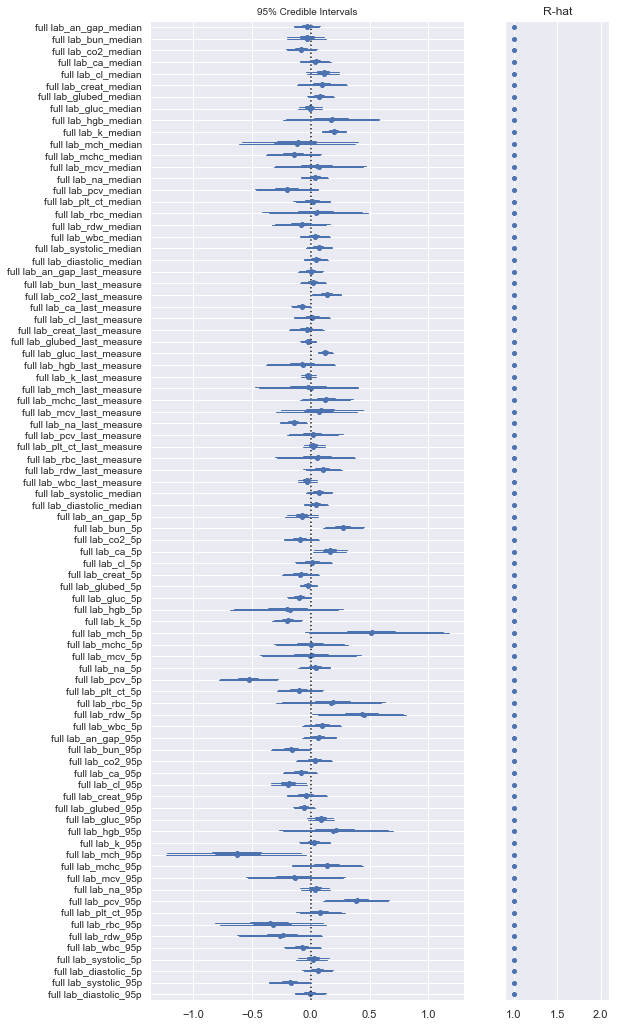

In [205]:
plt.rcParams['figure.figsize'] = [12,16]

forestplot(full_trace, varnames = labs_median + labs_last + labs_extremes, models = ['full']);

The full model has wider credible intervals on everything due to the problem noted before with highly correlated variables in the model.

## Model comparisons & posterior predictive accuracy

In [35]:
all_models = {simple_model: simple_trace, visit_model: visit_trace, dx_model: dx_trace,
              labvar_model: labvar_trace, extended_model: extended_trace, 
              clinsignif_model: clinsignif_trace, full_model: full_trace}

In [36]:
comparison = pm.compare(all_models)

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/kkondratieff/an

In [208]:
comparison['model_name'] = ['full','clinsignif','extended','labvar','visit','dx','simple']
comparison

WAIC   pWAIC   dWAIC weight      SE    dSE var_warn  model_name
6    23426  172.18       0   0.63  143.92      0        1        full
5  23537.1    56.5  111.07   0.27  139.54  39.34        1  clinsignif
4  23940.3   66.55  514.23   0.01  137.41   56.6        1    extended
3  24130.3   27.64  704.28      0  133.48  64.99        1      labvar
2  24149.7   30.04  723.68   0.08   135.6  66.55        1       visit
1  24169.2    21.5  743.14      0  133.47  65.91        0          dx
0  24412.8    6.11  986.75      0  130.79  73.62        1      simple

Not unsurprisingly, WAIC identifies the full model as the best candidate, though the clinical significance model is not dramatically far behind it, suggesting we can do away with a lot of the lab variables and still achieve good performance (for a given value of "good"); this would have the advantage of yielding a somewhat more interpretable model.

This does somewhat suggest addition of additional information on the lab values beyond the standard deviations is important for the model--in no small part because of the aforementioned problem with the standard deviation being missing entirely if multiple labs aren't drawn for that hospital visit. Notably, the clinical significance model has an advantage on the model including diagnosis codes--which may imply these don't add much to our predictions.

A possible corrective would be to introduce a variable counting the number of labs of a given type drawn during the visit and interacting it with standard deviation; that way the weight on the variability measure would be estimated only in cases where we know it's possible to estimate it.

In [201]:
model_names = {simple_trace: 'simple model', full_trace: 'full model', visit_trace: 'visit-based model',
               dx_trace: 'diagnosis code model', labvar_trace: 'lab value model',
               extended_trace: 'extended model', 
               clinsignif_trace: 'clinical significance model'}

model_short_names = {simple_trace: 'simple', full_trace: 'full', visit_trace: 'visit',
               dx_trace: 'dx', labvar_trace: 'labvar',
               extended_trace: 'extended', 
               clinsignif_trace: 'clinsignif'}

In [204]:
def posterior_performance(trace, model, y = X.readmit_30d):
    # add precision, recall, f1
    
    mod_name = model_names[trace]
    ppc = pm.sample_ppc(trace, model = model, random_seed = 42)
    
    pred_correct = pd.DataFrame(ppc['y']) == y
    pred_pos = pd.DataFrame(ppc['y']) == 1 
    true_pos = np.sum(pred_correct & pred_pos,axis = 1)
    all_pos = np.sum(pred_pos, axis = 1)
    n_cases = y.sum()
    
    recall = (true_pos/n_cases).mean()
    precision = (true_pos/all_pos).mean()
    f1 = 2*(precision*recall)/(precision+recall)
    accuracy = np.mean(pred_correct.mean(axis = 0))
    q5, q95 = np.percentile(pred_correct.mean(axis = 0), [5,95])
    
    performance = {'recall': recall, 'precision': precision, 'f1': f1, 'accuracy': accuracy, 'acc_q5': q5, 'acc_q95': q95}
    
    print('Accuracy for {mod}: {acc}%'.format(mod = mod_name, acc=(accuracy*100).round(2)))
    return ppc, performance

In [110]:
posterior_performance(simple_trace,simple_model)

100%|██████████| 2000/2000 [00:07<00:00, 261.29it/s]


Accuracy for simple model: 61.07%


(defaultdict(list, {'y': array([[1, 0, 0, ..., 0, 1, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 1, ..., 1, 0, 1],
                     ...,
                     [1, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 1, 0],
                     [1, 0, 1, ..., 0, 0, 0]])}),
 {'recall': 0.27597132301196337,
  'precision': 0.2760998489609744,
  'f1': 0.2760355710256084,
  'accuracy': 0.6106510433918516})

In [202]:
sample_ppcs = {}
performance = {}

for key in all_models:
    
    trace = all_models[key]
    model = key
    mod_name = model_short_names[trace]
    ppc, acc = posterior_performance(trace, model)
    sample_ppcs[mod_name] = ppc
    performance[mod_name] = acc

  1%|          | 23/2000 [00:00<00:08, 228.54it/s]

Accuracy for simple model: 61.07%


  1%|          | 21/2000 [00:00<00:09, 206.93it/s]

Accuracy for visit-based model: 61.6%


  1%|          | 21/2000 [00:00<00:09, 207.00it/s]

Accuracy for diagnosis code model: 61.69%


  1%|          | 15/2000 [00:00<00:13, 144.34it/s]

Accuracy for lab value model: 61.67%


  1%|          | 16/2000 [00:00<00:12, 153.26it/s]

Accuracy for extended model: 62.2%


  0%|          | 9/2000 [00:00<00:24, 82.58it/s]

Accuracy for clinical significance model: 62.94%


100%|██████████| 2000/2000 [00:20<00:00, 97.27it/s] 


Accuracy for full model: 63.59%


In [203]:
pd.DataFrame(performance).round(4).T

acc_q5  acc_q95  accuracy      f1  precision  recall
simple      0.2375   0.8005    0.6107  0.2760     0.2761  0.2760
visit       0.2290   0.8180    0.6160  0.2859     0.2860  0.2858
dx          0.2300   0.8115    0.6169  0.2879     0.2879  0.2879
labvar      0.2230   0.8280    0.6167  0.2873     0.2874  0.2873
extended    0.2190   0.8400    0.6220  0.2972     0.2973  0.2972
clinsignif  0.2055   0.8605    0.6294  0.3108     0.3109  0.3108
full        0.2015   0.8765    0.6359  0.3231     0.3231  0.3231

THAT'S ODD. YOU SHOULD NOT NECESSARILY NEED SHARED VARIABLES TO DO POSTERIOR PREDICTION THOUGH.

Not unsurprisingly, the full model performs best of all the available models, if only slightly--but even taken altogether, our collection of observed and engineered features does not do a very good job of predicting hospital readmissions.

Of course, as these test scores are computed on the training data set (I was unable to get PyMC3's GLM & Theano shared variables to play nicely together in the time I had, so could not do posterior prediction on the validation set; I potentially could have hand-built predictive models using the variable estimations to get around this problem), these predictive accuracies should be taken with a grain of salt--actual performance in the wild would probably be worse, and the 5th & 95th percentiles for model accuracy based on the PPC samples gives an idea of just how much it *could* vary.

Making one final cut at modeling based on all the above (though now that I've looked at the variables I'm a filthy cheater):

In [13]:
X = pd.concat([train,valid,test]).drop('Unnamed: 0', axis = 1).reset_index(drop = True)
X.columns = list(X.columns.str.replace(" |, |\.","_").str.lower())

X['bmi_sqrd'] = X['bmi_last']**2

trans_var = ['age'] + labs + ['bmi_last'] + ['bmi_sqrd'] + cpts
scaler = preprocessing.StandardScaler()

X[trans_var] = scaler.fit_transform(X[trans_var])

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
clin_cpts = ['n_transfers', 'stay_length', 'cpt_path_lab', 'cpt_surgery', 'cpt_radiology', 'cpt_anesthesia']

In [16]:
final_model, final_trace = model_gen(variables = demos + bmi + ['bmi_sqrd'] + clin_cpts + labs_var + labs_last, data = X, draws = 2000)

logp = -12,134, ||grad|| = 1.2346: 100%|██████████| 83/83 [00:00<00:00, 211.26it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lab_diastolic_median, lab_systolic_median, lab_wbc_last_measure, lab_rdw_last_measure, lab_rbc_last_measure, lab_plt_ct_last_measure, lab_pcv_last_measure, lab_na_last_measure, lab_mcv_last_measure, lab_mchc_last_measure, lab_mch_last_measure, lab_k_last_measure, lab_hgb_last_measure, lab_gluc_last_measure, lab_glubed_last_measure, lab_creat_last_measure, lab_cl_last_measure, lab_ca_last_measure, lab_co2_last_measure, lab_bun_last_measure, lab_an_gap_last_measure, lab_diastolic_std, lab_systolic_std, lab_wbc_std, lab_rdw_std, lab_rbc_std, lab_plt_ct_std, lab_pcv_std, lab_na_std, lab_mcv_std, lab_mchc_std, lab_mch_std, lab_k_std, lab_hgb_std, lab_gluc_std, lab_glubed_std, lab_creat_std, lab_cl_std, lab_ca_std, lab_co2_std, lab_bun_std, lab_an_gap_std, cpt_anesthesia, cpt_radiolo

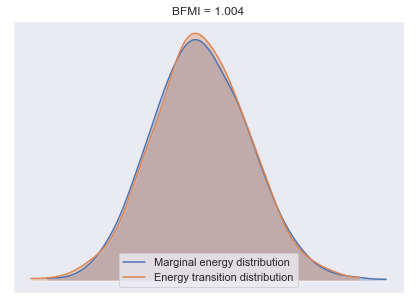

In [17]:
plt.rcParams['figure.figsize'] = [7,5]
energyplot(final_trace);
plt.title('BFMI = {}'.format(bfmi(final_trace).round(3)));

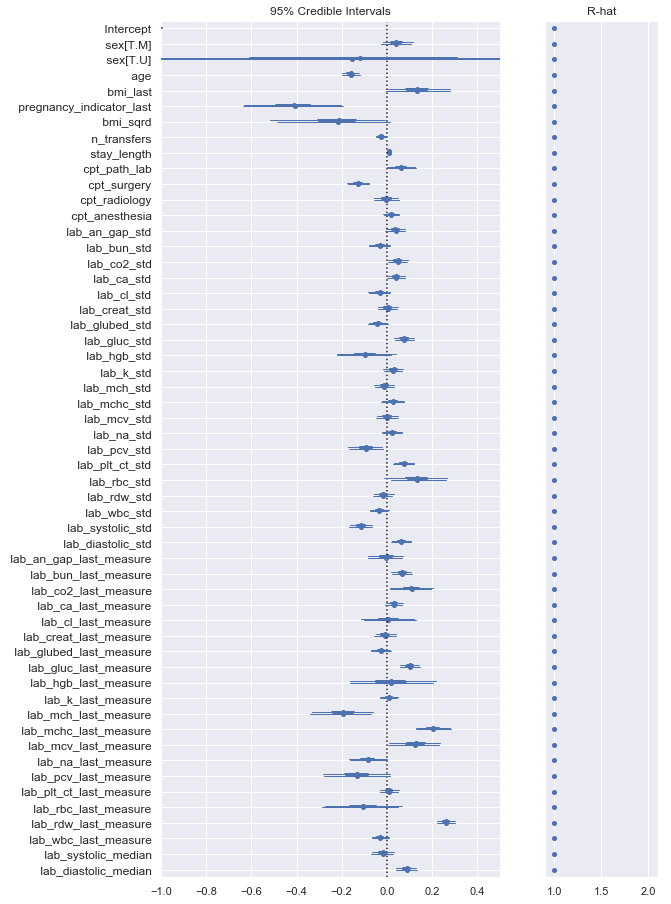

In [18]:
plt.rcParams['figure.figsize'] = [12,14]
forestplot(final_trace, xlim = [-1,0.5]);

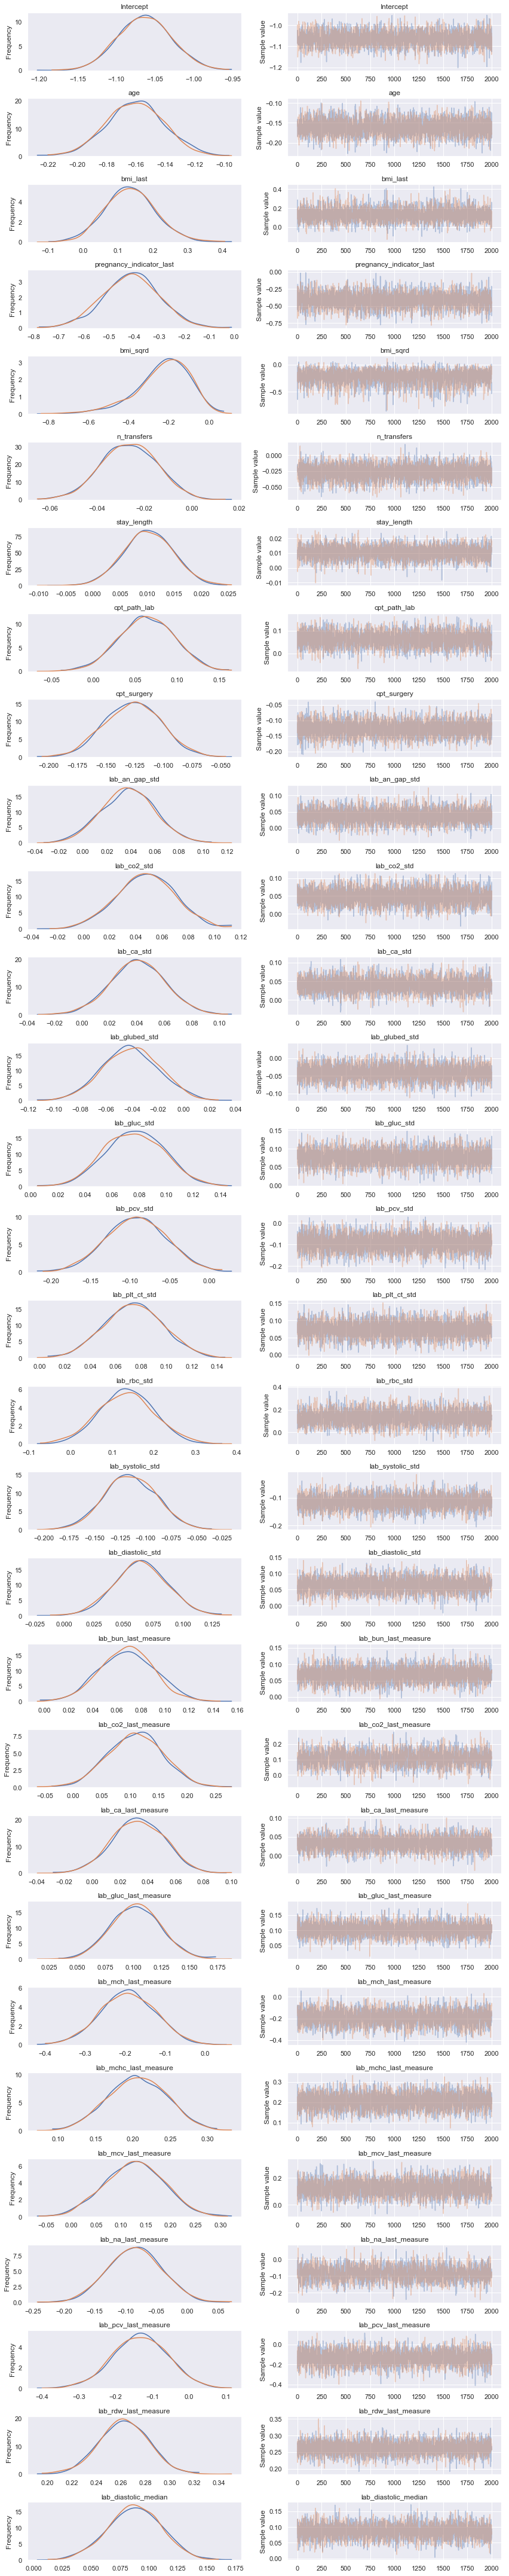

In [21]:
traceplot(final_trace, varnames = var_selector(final_trace, cutoff = 0.95));

In [22]:
def posterior_performance(trace, model, name, y = X.readmit_30d):
    ppc = pm.sample_ppc(trace, model = model, random_seed = 42)
    
    pred_correct = pd.DataFrame(ppc['y']) == y
    pred_pos = pd.DataFrame(ppc['y']) == 1 
    true_pos = np.sum(pred_correct & pred_pos,axis = 1)
    all_pos = np.sum(pred_pos, axis = 1)
    n_cases = y.sum()
    
    recall = (true_pos/n_cases).mean()
    precision = (true_pos/all_pos).mean()
    f1 = 2*(precision*recall)/(precision+recall)
    accuracy = np.mean(pred_correct.mean(axis = 0))
    q5, q95 = np.percentile(pred_correct.mean(axis = 0), [5,95])
    
    performance = {'recall': recall, 'precision': precision, 'f1': f1, 'accuracy': accuracy, 'acc_q5': q5, 'acc_q95': q95}
    
    print('Accuracy for {mod}: {acc}%'.format(mod = name, acc=(accuracy*100).round(2)))
    return ppc, performance

In [23]:
final_ppc, final_perf = posterior_performance(final_trace, final_model, name = "final model")
pd.DataFrame(final_perf, range(1))

100%|██████████| 2000/2000 [00:11<00:00, 172.60it/s]


Accuracy for final model: 62.95%


recall  precision        f1  accuracy  acc_q5  acc_q95
0  0.311022    0.31111  0.311066  0.629453  0.2055   0.8605

Comparatively, it doesn't do too bad -- and beats out the full model for interpretability. The inclusion of the BMI^2 has also flipped the posterior estimate for BMI & made it tighter, implying their is some nonlinearity in the response here. So that's cool!

SO WHAT WAS THE CLASS BALANCE LIKE? HARD TO INTERPRET ACCURACY.